In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
harmon=pd.read_csv('Harmon.csv')

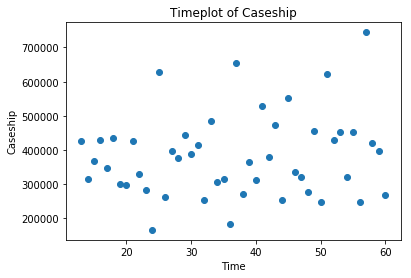

In [4]:
from matplotlib import pyplot as plt
harmon['TimeIndex']=np.arange(1,61)
plt.plot(harmon['TimeIndex'],harmon['Caseship'],'o')
plt.title('Timeplot of Caseship')
plt.xlabel('Time')
plt.ylabel('Caseship')
plt.show()

In [5]:
import statsmodels.formula.api as smf
reg_fit = smf.ols(formula='Caseship ~ TimeIndex', data=harmon).fit()
print (reg_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               Caseship   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.046
Date:                Tue, 06 Feb 2018   Prob (F-statistic):              0.312
Time:                        11:26:02   Log-Likelihood:                -628.90
No. Observations:                  48   AIC:                             1262.
Df Residuals:                      46   BIC:                             1266.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.354e+05   4.93e+04      6.809      0.0

In [4]:
new_x=pd.DataFrame(data={'TimeIndex':[61]})
pred=reg_fit.get_prediction(new_x)
pred.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,414137.807624,35515.133156,342649.552528,485626.062721,160089.167799,668186.447449


# Extra variable prep.

In [6]:
temp=harmon.dropna(subset=['SIndex'])['SIndex']
harmon['SIndexAll']=np.tile(temp.values,5)
harmon['desCases']=harmon['Caseship']/(harmon['SIndexAll']/100)
harmon['CP_Lag1']=harmon['Conpacks'].shift(1)
harmon['CP_Lag2']=harmon['Conpacks'].shift(2)
harmon['DA_Lag1']=harmon['DealAl'].shift(1)
harmon['DA_Lag2']=harmon['DealAl'].shift(2)

# By multiple regression

In [7]:
mreg_fit = smf.ols(formula='desCases~Conpacks+DealAl+TimeIndex+CP_Lag1+CP_Lag2+DA_Lag1+DA_Lag2', data=harmon).fit()
print (mreg_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               desCases   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     36.26
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           2.24e-15
Time:                        11:26:09   Log-Likelihood:                -566.56
No. Observations:                  48   AIC:                             1149.
Df Residuals:                      40   BIC:                             1164.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.946e+05    1.5e+04     19.689      0.0

# Test for heteroskedasticity
* **het_breuschpagan** from **statsmodels.stats.diagnostic** package conduct BP test
* Notice that this BP test is a modifcation version and different from ncvTest of R
* It returns 4 values, the first and the second are the test-statistics and p-value

In [133]:
#Notice that this BP test is a modifcation version and different from ncvTest of R
import statsmodels.stats.diagnostic as ssd
BP=ssd.het_breuschpagan(mreg_fit.resid, mreg_fit.model.exog)
print ('Test-statistics:',BP[0])
print ('p-value:',BP[1])


Test-statistics: 8.17221435779
p-value: 0.317653577296


## Diagnostic of the residuals

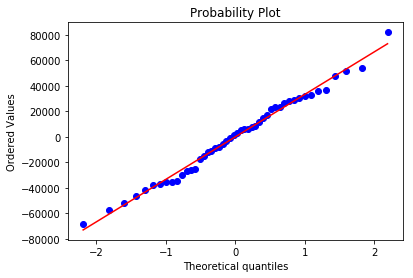

In [8]:
import scipy.stats as scipystats
import pylab
scipystats.probplot(mreg_fit.resid, dist="norm", plot=pylab)
pylab.show()

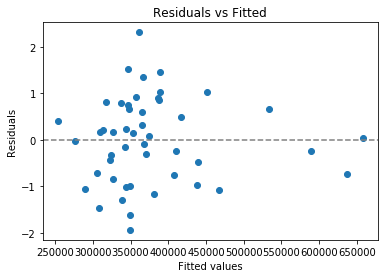

In [11]:
residsvfitted = plt.plot(mreg_fit.fittedvalues, mreg_fit.resid_pearson,  'o')
l = plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show(residsvfitted)

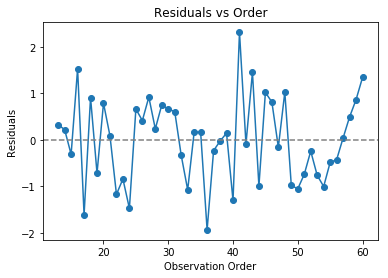

In [12]:
residsvobs = plt.plot(harmon.dropna(subset=['Caseship'])['TimeIndex'],mreg_fit.resid_pearson ,  '-o')
l = plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.title('Residuals vs Order')
plt.show(residsvobs)

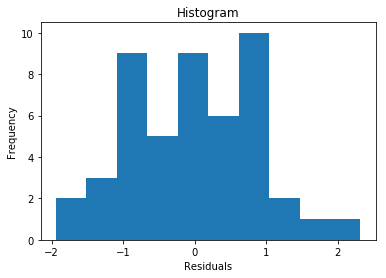

In [13]:
plt.hist(mreg_fit.resid_pearson,histtype='stepfilled')
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.title('Histogram')
plt.show()

# VIF

In [14]:
import statsmodels.formula.api as sm
def vif_cal(input_data):
    x_vars=input_data
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

In [15]:
vif_cal(harmon.dropna(subset=['Caseship']).loc[:,{'Conpacks','DealAl','TimeIndex','CP_Lag1','CP_Lag2','DA_Lag1','DA_Lag2'}])

CP_Lag1  VIF =  1.31
TimeIndex  VIF =  1.44
Conpacks  VIF =  1.27
DA_Lag2  VIF =  1.3
CP_Lag2  VIF =  1.28
DA_Lag1  VIF =  1.35
DealAl  VIF =  1.29


In [16]:
new_data=pd.DataFrame({'Conpacks':[200000],'DealAl':[120000],'TimeIndex':[61],'CP_Lag1':[71881],'CP_Lag2':[234562],'DA_Lag1':[552536],'DA_Lag2':[376556]})
pred=mreg_fit.get_prediction(new_data)
pred.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,421758.011033,13558.190562,394355.88585,449160.136217,345072.621701,498443.400366


# Cochrane-Orcutt procedure

In [126]:
import statsmodels.api as sm
temp=sm.OLS(mreg_fit.resid[1:],sm.add_constant(mreg_fit.resid.shift(1)[1:])).fit()
temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.3827
Date:                Tue, 06 Feb 2018   Prob (F-statistic):              0.539
Time:                        15:10:37   Log-Likelihood:                -554.99
No. Observations:                  47   AIC:                             1114.
Df Residuals:                      45   BIC:                             1118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -340.4913   4848.793     -0.070      0.944   -1.01e+04    9425.478
0             -0.0939      0.152     -0.619      0.539      -0.400       0.212
==============================================================================
Omnibus:                        0.769   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.768
Skew:                           0.050   Prob(JB):                        0.681
Kurtosis:                       2.382   Cond. No.                     3.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# By time series model

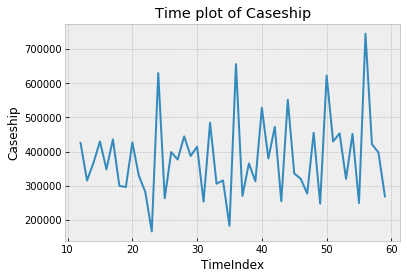

In [131]:
Caseship13=harmon.dropna(subset=['Caseship'])['Caseship']
plt.plot(Caseship13)
plt.xlabel('TimeIndex')
plt.ylabel('Caseship')
plt.title('Time plot of Caseship')
plt.show()

# ADF Test
* **adfuller** from **statsmodels.tsa.stattools** conducts this test
* The default setting is quite different from **adf.test** of **R**
    * the following setup is the closest to that of **R**
    * autolag=None,regression='ct',maxlag=np.int(np.ceil((nobs-1)**(1/3)))
    * where **nobs** is the number of observation

In [44]:
from statsmodels.tsa.stattools import adfuller
nobs=Caseship13.shape[0]
result=adfuller(np.array(Caseship13),autolag=None,regression='ct',maxlag=np.int(np.ceil((nobs-1)**(1/3))))
print ('Test-Statistics:',result[0])
print ('p-value:',result[1])

Test-Statistics: -3.89850897539
p-value: 0.0121902205522


* suggesting stationary and hence differencing is not necessary

# ACF and PACF

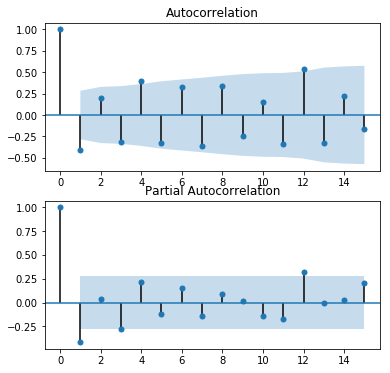

In [78]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from matplotlib import pyplot

plt.figure(figsize=(6,6))
plt.subplot(211)
plot_acf(Caseship13, ax=pyplot.gca(),lags=15)
plt.subplot(212)
plot_pacf(Caseship13, ax=pyplot.gca(),lags=15)
plt.show()

* Possible candidate: AR(1)

# Auto order selection
* Python has a function to determine the orders automatically, only for AR and MA components 
* **arma_order_select_ic** from **statsmodels.tsa.stattools**

In [125]:
import statsmodels.tsa.stattools as sts

result=sts.arma_order_select_ic(np.array(Caseship13))
print ('Order for AR:',result.bic_min_order[0])
print ('Order for MA:',result.bic_min_order[1])

Order for AR: 1
Order for MA: 0


* Same as what we though before

# ARIMA model
* **ARIMA** from **statsmodels.tsa.arima_model** fits the ARIMA model

In [62]:
from statsmodels.tsa.arima_model import ARIMA
ar1 = ARIMA(np.array(Caseship13), order=(1,0,0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                     ARMA(1, 0)   Log Likelihood                -624.898
Method:                       css-mle   S.D. of innovations         108857.003
Date:                Tue, 06 Feb 2018   AIC                           1255.795
Time:                        13:22:31   BIC                           1261.409
Sample:                             0   HQIC                          1257.916
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.825e+05   1.12e+04     34.233      0.000    3.61e+05    4.04e+05
ar.L1.y       -0.4150      0.131     -3.179      0.003      -0.671      -0.159
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.4095           +0.0000j            2.4095            0.5000
-----------------------------------------------------------------------------
"""

# Diagnostic of the residuals of ARIMA(1,0,0):

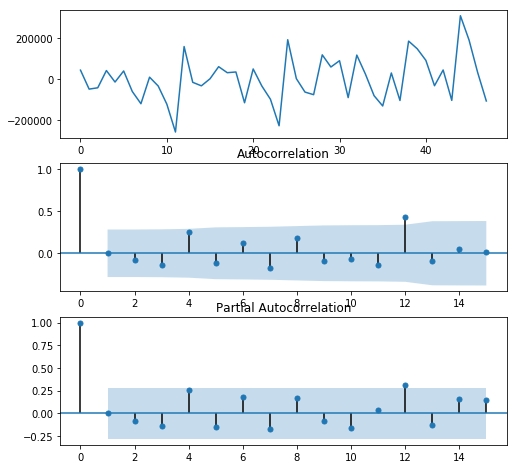

In [77]:
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(ar1.resid)
plt.subplot(312)
plot_acf(ar1.resid, ax=pyplot.gca(),lags=15)
plt.subplot(313)
plot_pacf(ar1.resid, ax=pyplot.gca(),lags=15)
plt.show()

* The residuals seems to be uncorrelated

# Forecast for longer horizon:

In [119]:
n_steps = 10

f, err95, ci95 = ar1.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = ar1.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = np.arange(60,60+n_steps)
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
60,429596.915429,216241.109477,149199.856407,642952.721381,709993.974450
61,362984.446105,131983.184477,59397.327387,593985.707733,666571.564824
62,390630.525615,156724.208824,83225.517244,624536.842406,698035.533987
63,379156.612097,144753.538093,71098.754083,613559.686100,687214.470110
64,383918.614296,149430.080737,75748.443389,618407.147855,692088.785203


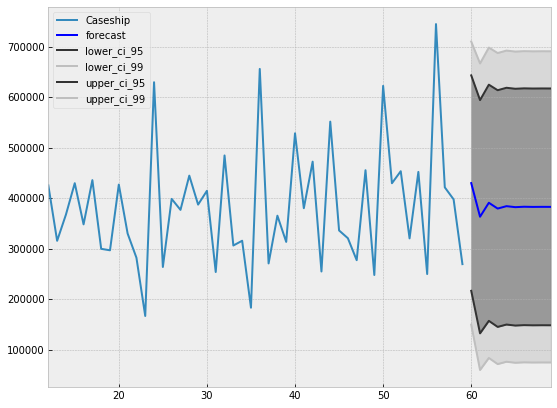

In [120]:
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

plt.plot(Caseship13)
styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.legend(loc='best', fontsize=10)
plt.show()

# Error Measurement

In [140]:
#mreg
msd_mreg=np.mean(mreg_fit.resid**2)
mad_mreg=np.mean(np.abs(mreg_fit.resid))
mape_mreg=np.mean(np.abs(mreg_fit.resid/Caseship13))*100

#ar1
msd_ar1=np.mean(ar1.resid**2)
mad_ar1=np.mean(np.abs(ar1.resid))
mape_ar1=np.mean(np.abs(ar1.resid/Caseship13))*100


In [146]:
print('MSD of multi. reg.:' ,msd_mreg)
print('MAD of multi. reg.:', mad_mreg)
print('MAPE of multi. reg.:', mape_mreg)

MSD of multi. reg.: 1046530360.4504863
MAD of multi. reg.: 26571.387863615902
MAPE of multi. reg.: 7.995748575790673


In [147]:
print('MSD of ar1:' ,msd_ar1)
print('MAD of ar1:', mad_ar1)
print('MAPE of ar1:', mape_ar1)

MSD of ar1: 11856345126.1
MAD of ar1: 85362.064114
MAPE of ar1: 25.328697402898758
